In [1]:
import json
import pandas as pd
import datetime
import numpy as np
from pycountry_convert import convert_country_alpha2_to_continent
from data_handling import utc_convert
import matplotlib.dates as mdates
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

pd.options.display.max_colwidth = 200

In [ ]:
# CLustering
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler

# Prep data

In [4]:
from marvin_data_prep import load_data, prepare_data, separate_os

In [2]:
#plot and data mining
from marvin_auxiliary_functions import make_screen_vector,plot_time_vs_screen_vs_interaction

In [5]:
df = load_data('anonymisedapp', 50)
df = prepare_data(df, 'anonymisedapp')
df = separate_os(df)
print(len(df))

5552


In [4]:
df.head(3)

,app_id,app_version,company_name,crash_log,device_class,device_model_name,device_id,device_name,device_run,device_run_name,...,time_formatted,country_name,country_code,weekday,continent,screens_visited,screen_number,time_per_screen,interaction_information,interaction_number
1,588f2a6aff6059ffff8b45b1,1.2 (1701301632),Apple,false,iPhone 7,iPhone 7,6c705f66cbf05fe658f46f286aea07f5,6c705f66cbf05fe658f46f286aea07f5,8,Session 13,...,2017-01-30 16:47:13,Denmark,dk,0,Europe,"[UploadViewController, PhotoStreamViewController, PurchaseViewController, CouponModalViewController, UIAlertController]",5,22.800000,"[{'interaction_count': 3, '_screen': 'UploadViewController', 'interaction_time': [0.575350999832, 0.577283024788, 0.650696992874], 'view_time': 1.1993860006332, 'start_time': 0}, {'interact...",35
2,588f2a6aff6059ffff8b45b1,1.2 (1701301632),Apple,false,iPhone 7,iPhone 7,6c705f66cbf05fe658f46f286aea07f5,6c705f66cbf05fe658f46f286aea07f5,9,Session 14,...,2017-01-30 16:49:31,Denmark,dk,0,Europe,"[UIAlertController, EventPageViewController, PhotoStreamViewController, EventPageViewController, UIAlertController]",5,21.800000,"[{'interaction_count': 11, '_screen': 'UIAlertController', 'interaction_time': [1.88326698542, 1.88436001539, 1.94978702068, 2.91884100437, 2.99987101555, 10.4188929796, 10.5172550082, 11.16986596...",32
3,588f2a6aff6059ffff8b45b1,1.2 (1701301632),Apple,false,iPhone 7,iPhone 7,6c705f66cbf05fe658f46f286aea07f5,6c705f66cbf05fe658f46f286aea07f5,10,Session 15,...,2017-01-30 16:51:32,Denmark,dk,0,Europe,"[UIAlertController, SupportViewController, MFMailComposeRemoteViewController]",3,25.333333,"[{'interaction_count': 5, '_screen': 'UIAlertController', 'interaction_time': [0.104194998741, 0.104668974876, 0.170804977417, 1.35482496023, 1.43797898293], 'view_time': 1.4541319608688, 'start_t...",8


In [5]:
df[df.columns[pd.Series(df.columns).str.startswith('device')]].head()

,device_class,device_model_name,device_id,device_name,device_run,device_run_name,device_run_notes,device_type
1,iPhone 7,iPhone 7,6c705f66cbf05fe658f46f286aea07f5,6c705f66cbf05fe658f46f286aea07f5,8,Session 13,,iphone
2,iPhone 7,iPhone 7,6c705f66cbf05fe658f46f286aea07f5,6c705f66cbf05fe658f46f286aea07f5,9,Session 14,,iphone
3,iPhone 7,iPhone 7,6c705f66cbf05fe658f46f286aea07f5,6c705f66cbf05fe658f46f286aea07f5,10,Session 15,,iphone
4,iPhone 7,iPhone 7,6c705f66cbf05fe658f46f286aea07f5,6c705f66cbf05fe658f46f286aea07f5,11,Session 16,,iphone
5,iPhone 7,iPhone 7,6c705f66cbf05fe658f46f286aea07f5,6c705f66cbf05fe658f46f286aea07f5,12,Session 17,,iphone


In [6]:
df[df.columns[pd.Series(df.columns).str.startswith('os')]].head()

,os_lname,os_name,os_name_float
1,10.1.1,10.1.1,10.1
2,10.1.1,10.1.1,10.1
3,10.1.1,10.1.1,10.1
4,10.1.1,10.1.1,10.1
5,10.1.1,10.1.1,10.1


In [6]:
df.app_version.value_counts()

1.3 (1701312221)    4695
1.4 (1702161135)     692
1.2 (1701301632)      52
1.2 (1701311441)      38
1.3 (1702152310)      38
1.3 (1702131651)      20
1.3 (1702141609)      10
1.3 (1701311441)       6
1.4 (1702152310)       1
Name: app_version, dtype: int64

# Screens

In [5]:
df['country_name'].value_counts()

Denmark          356
Australia        249
United States    134
Germany          129
Sweden            86
Netherlands       41
Greece            28
Switzerland       14
Austria            9
Unknown            9
Latvia             2
Russia             2
Mexico             1
Norway             1
India              1
Name: country_name, dtype: int64

In [7]:
print(len(df[df.total_time < 120])/float(len(df)) * 100,'%')

79.75517890772127 %


Conclusion: Total_time is overwhelmingly under 2 minutes

## Summary Statisitics of screen_number

In [5]:
df.screen_number.describe()

count    5552.000000
mean        5.011167
std         5.995514
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        70.000000
Name: screen_number, dtype: float64

In [7]:
np.percentile(df.screen_number, 90)

11.0

F:\Python\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


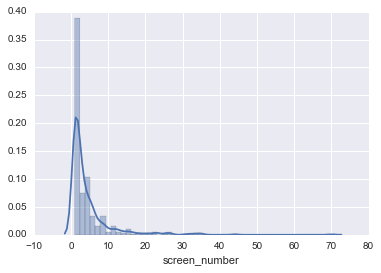

In [12]:
sns.distplot(df.screen_number)

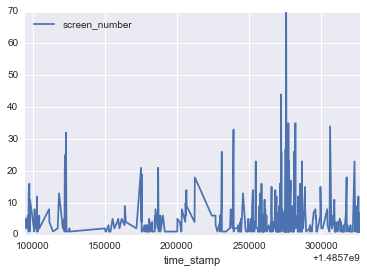

In [13]:
df.plot('time_stamp','screen_number')

In [14]:
df_day = df.groupby('ymd').sum()

In [15]:
df_day

,device_run,height,is_crash,is_favorite,os_name_float,resolution,time_stamp,total_time,unplayed,width,weekday,screen_number,time_per_screen,first_time_stage,photo_viewer_stage,active_use_stage,beneficial_action_stage
ymd,,,,,,,,,,,,,,,,,
2017-01-30,355,22678,0,0,344.7,11084,50517298863,3592,29,12750,0,153,1097.847261,1,33,13,7
2017-01-31,691,92187,0,0,793.9,32280,133728636746,25322,75,52935,90,381,17329.386995,3,48,44,28
2017-02-01,1248,260750,1,0,2759.1,107297,436874264521,43863,244,147698,588,1477,17252.309822,85,88,91,100
2017-02-02,285,161889,4,0,866.3,49641,163461718721,10080,105,92027,330,369,4115.914672,16,9,4,38


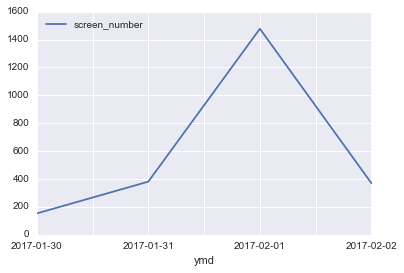

In [16]:
df_day.plot(y='screen_number', use_index = True)

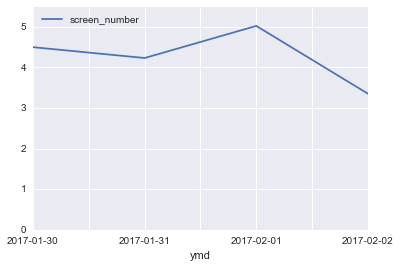

In [17]:
df_day_avg = df[['ymd','screen_number']].groupby('ymd').mean()
df_day_avg.plot(y='screen_number', use_index = True, yticks = range(0,6,1))

In [18]:
dfs = df[['id','ymd','device_model_name','country_name','screen_number']]

In [19]:
dfs.device_model_name.value_counts()

iPhone 7            124
iPhone 6s           124
iPhone 6             63
iPhone 5s            30
SM-G920I             16
SM-G930F             13
HTC One              12
iPhone 7 Plus        12
Nexus 5X             11
SM-A500H             10
iPhone 6SE           10
Nexus 6               9
SM-G930T              8
iPhone 6s Plus        7
VS986                 7
SM-G550T2             7
SM-A300Y              7
iPhone 5c             6
HTC Desire 626s       5
SM-G920F              4
SM-G935F              4
SM-G900P              4
Z981                  4
iPhone 4s             3
iPhone 6 Plus         3
iPhone 5              3
SM-G928I              3
SCH-I435              2
LGMS330               2
SM-N920I              2
SAMSUNG-SM-G935A      2
Moto G (4)            1
XT1254                1
SM-G800F              1
Pixel                 1
SM-G900I              1
LGL33L                1
SM-G925F              1
SM-A510F              1
iPad Air 2            1
D5803                 1
SAMSUNG-SM-G925A

In [20]:
pd.pivot_table(df,index=['country_name','device_model_name'],values=['screen_number'],aggfunc=np.mean)

screen_number
country_name  device_model_name               
Australia     SM-A300Y                1.857143
              SM-G900I                2.000000
              SM-G920I                1.812500
              SM-G930F                1.375000
              SM-G935F                3.000000
              SM-N920I                1.500000
              iPhone 5                6.000000
              iPhone 5s               3.500000
              iPhone 6                5.166667
              iPhone 6s               4.357143
              iPhone 6s Plus          5.000000
              iPhone 7                5.833333
              iPhone 7 Plus          19.500000
Austria       iPhone 6                4.666667
Denmark       HTC One                 2.500000
              Nexus 5X                1.875000
              Nexus 6                 1.333333
              SM-A500H                1.900000
              SM-G925F                1.000000
              iPhone 4s               2.000000
              iPhone 5                4.000000
              iPhone 5c              16.666667
              iPhone 5s               4.277778
              iPhone 6                5.520000
              iPhone 6SE              4.800000
              iPhone 6s               3.964912
              iPhone 7                4.620253
              iPhone 7 Plus           2.000000
Germany       D5803                   1.000000
              SM-A510F                2.000000
...                                        ...
Netherlands   SM-G800F                5.000000
              iPhone 7                5.375000
Norway        iPhone 6                1.000000
Sweden        SM-G935F                1.000000
              iPhone 6                7.000000
              iPhone 6s               6.187500
Switzerland   iPhone 5s               1.000000
              iPhone 7                4.500000
              iPhone 7 Plus           1.000000
United States HTC Desire 626s         1.200000
              LGL33L                  2.000000
              LGMS330                 2.500000
              Pixel                   3.000000
              SAMSUNG-SM-G925A        2.000000
              SAMSUNG-SM-G935A        1.000000
              SCH-I435                1.500000
              SM-G550T2               1.857143
              SM-G900P                2.000000
              SM-G930T                1.750000
              VS986                   1.428571
              XT1254                  1.000000
              Z981                    1.750000
              iPad Air 2              1.000000
              iPhone 5s               3.500000
              iPhone 6                5.600000
              iPhone 6 Plus           2.500000
              iPhone 6s               7.000000
              iPhone 6s Plus         19.500000
              iPhone 7 Plus           9.600000
Unknown       SM-G928I                1.666667

[75 rows x 1 columns]

# Distribution of screen_number

In [7]:
countries = set(df.country_name)

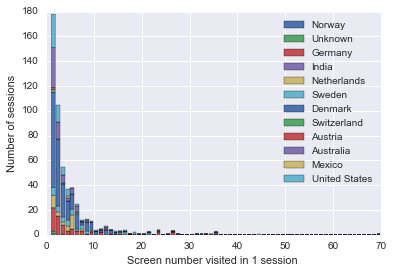

In [81]:
plt.hist([df['screen_number'][df.country_name == country] for country in countries], stacked=True, label = countries, 
         bins = np.linspace(1,max(df.screen_number),max(df.screen_number)))
plt.legend()
ax=plt.gca()
ax.set_xlabel('Screen number visited in 1 session ')
ax.set_ylabel('Number of sessions')

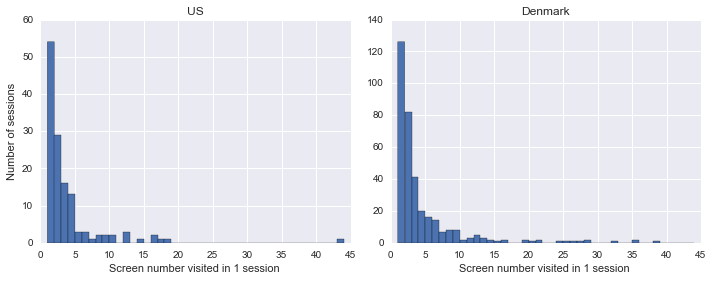

In [10]:
fig=plt.figure(figsize = [10, 4])
ax1=fig.add_subplot(121)
usa_screen_number = df['screen_number'][df.country_name == 'United States']
plt.hist(usa_screen_number, bins = np.linspace(1,max(usa_screen_number),max(usa_screen_number)))
ax1.set_xlabel('Screen number visited in 1 session ')
ax1.set_ylabel('Number of sessions')
plt.title('US')

ax2=fig.add_subplot(122)
denmark_screen_number = df['screen_number'][df.country_name == 'Denmark']
plt.hist(denmark_screen_number, bins = np.linspace(1,max(usa_screen_number),max(usa_screen_number)))
ax2.set_xlabel('Screen number visited in 1 session ')
plt.title('Denmark')

plt.tight_layout()

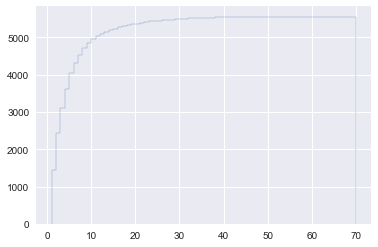

In [12]:
plt.hist(df.screen_number, cumulative=True, bins = np.linspace(1,max(df.screen_number),max(df.screen_number)), histtype='step')
plt.show()

F:\Python\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


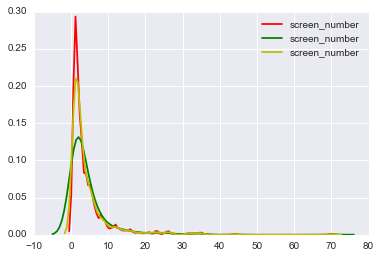

In [24]:
sns.kdeplot(df.screen_number, bw = 0.5, color = 'r')
sns.kdeplot(df.screen_number, bw = 2, color = 'g')

sns.kdeplot(df.screen_number, color = 'y')

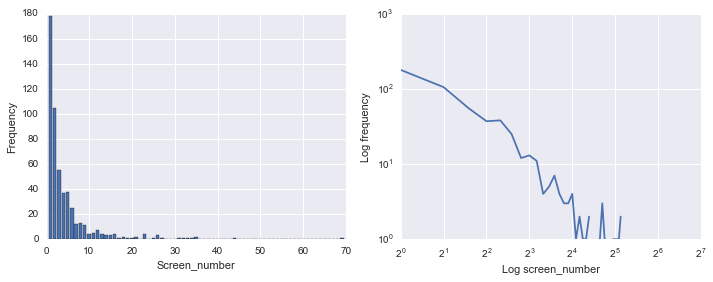

In [100]:
fig = plt.figure(figsize=[10,4])
ax1 = fig.add_subplot(121)
freq, bins = np.histogram(df.screen_number, bins = np.linspace(1,max(df.screen_number),max(df.screen_number)))
screens = bins[:-1]
plt.bar(screens, freq, align='center')
ax1.set_xlabel('Screen_number')
ax1.set_ylabel('Frequency')

ax2 = fig.add_subplot(122)
plt.loglog(screens, freq, basex = 2)
ax2.set_xlabel('Log screen_number')
ax2.set_ylabel('Log frequency')

plt.tight_layout()

How to determined cut-off point?

# Distribution of total_time

In [9]:
df.total_time.describe()

count    5552.000000
mean       86.226945
std       187.621513
min         1.000000
25%        18.000000
50%        44.000000
75%       100.000000
max      6840.000000
Name: total_time, dtype: float64

In [68]:
np.percentile(df.total_time, 90)

198.0

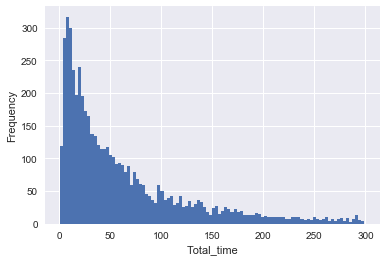

In [13]:
df.total_time[df.total_time < 300].hist(bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Total_time')

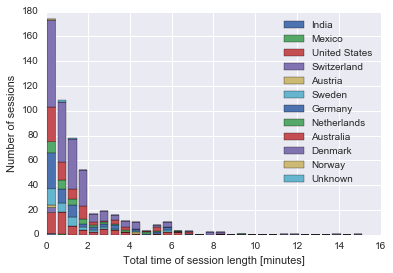

In [8]:
plt.hist([df['total_time'][df['total_time'] < 1000][df.country_name == country] / 60. for country in countries], 
             stacked=True, label = countries, bins = 30)
plt.legend()
ax=plt.gca()
ax.set_xlabel('Total time of session length [minutes]')
ax.set_ylabel('Number of sessions')

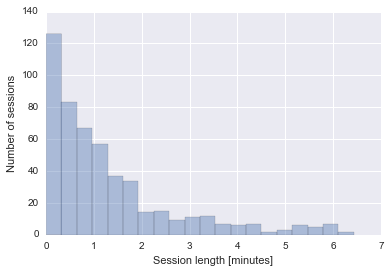

In [5]:
sns.distplot(df.loc[df['total_time'] < 400]['total_time'] / 60., kde=False)
ax=plt.gca()
ax.set_xlabel('Session length [minutes]')
ax.set_ylabel('Number of sessions')

## Calculating screen_score and time_score (deprecated)

In [12]:
df[['screen_number', 'screen_score']].head(10)

,screen_number,screen_score
1,5,0.444444
2,5,0.444444
3,3,0.222222
4,2,0.111111
5,6,0.555556
6,1,0.000000
7,13,1.000000
8,16,1.000000
9,2,0.111111
10,1,0.000000


In [17]:
df[['screens_visited','total_time', 'time_score']].head(10)

,screens_visited,total_time,time_score
1,"[UploadViewController, PhotoStreamViewController, PurchaseViewController, CouponModalViewController, UIAlertController]",114,4.804046
2,"[UIAlertController, EventPageViewController, PhotoStreamViewController, EventPageViewController, UIAlertController]",109,4.593342
3,"[UIAlertController, SupportViewController, MFMailComposeRemoteViewController]",76,3.202697
4,"[SupportViewController, PhotoStreamViewController]",98,4.129794
5,"[PhotoStreamViewController, PurchaseViewController, PhotoStreamViewController, PurchaseViewController, CouponModalViewController, UIAlertController]",263,10.000000
6,[UIAlertController],119,5.014749
7,"[MenuController, PhotoStreamViewController, PurchaseViewController, CouponModalViewController, UIAlertController, PhotoStreamViewController, PurchaseViewC...",255,10.000000
8,"[MenuController, UploadViewController, MenuController, UploadViewController, CameraViewController, UploadViewController, MenuController, ImageViewe...",338,10.000000
9,"[PhotoStreamViewController, UploadViewController]",94,3.961231
10,[MenuController],8,0.337126


# Other plots

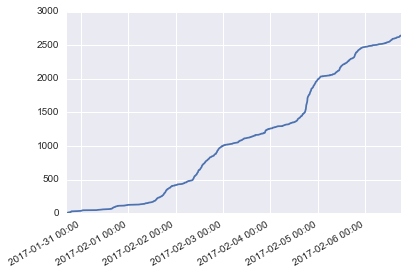

In [67]:
pd.Series(index=[np.sort(df['time_formatted'])],
              data=range(len(df))).plot(label='sessions')
ax=plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:00'))

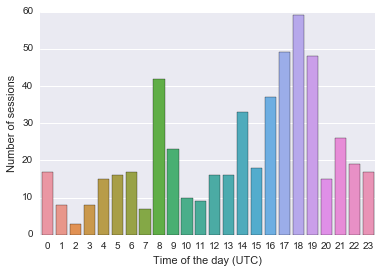

In [21]:
sns.barplot(data=df, y='total_time', x='time_of_the_day', estimator=len)
ax=plt.gca()
ax.set_xlabel('Time of the day (UTC)')
ax.set_ylabel('Number of sessions')

## Relationship between screen_number and total_time

In [20]:
# Remove duplicate values first for better plotting
df2 = df[['screen_number', 'total_time', 'interaction_number']].copy()
bins = [0,10,20,40,max(df2.interaction_number)+1]
df2['interaction_bin'] = pd.cut(df2['interaction_number'], bins, labels =[1,2,3,4])
df2['log_screen_number'] = np.log(df.screen_number)
df2['log_total_time'] = np.log(df.total_time)

df2 = df2.drop_duplicates()

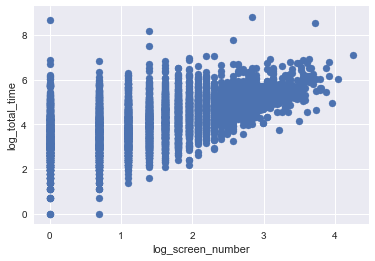

In [12]:
plt.scatter(x='log_screen_number', y='log_total_time', data=df2)
plt.xlabel('log_screen_number')
plt.ylabel('log_total_time')

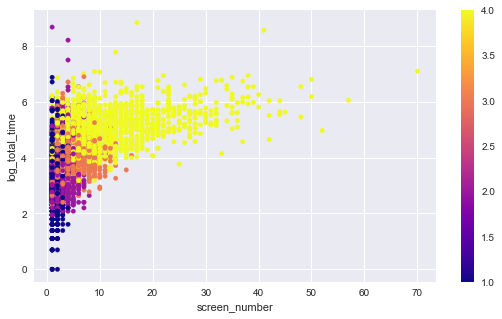

In [24]:
fig = plt.figure(figsize = [9,5])
plt.scatter(x='screen_number', y='log_total_time', c='interaction_bin', cmap='plasma', data=df2, s=20)
plt.xlabel('screen_number')
plt.ylabel('log_total_time')
plt.colorbar()

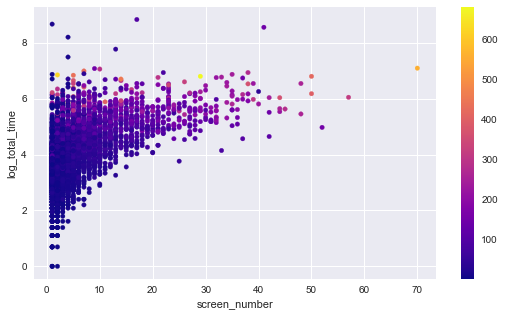

In [39]:
fig = plt.figure(figsize = [9,5])
plt.scatter(x='screen_number', y='log_total_time', c='interaction_number', cmap='plasma', data=df2, s=20)
plt.xlabel('screen_number')
plt.ylabel('log_total_time')

plt.colorbar()

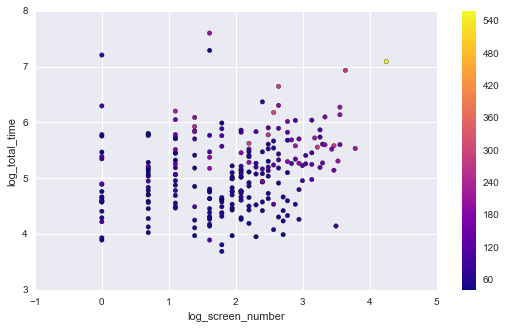

In [108]:
fig = plt.figure(figsize = [9,5])
plt.scatter(x='log_screen_number', y='log_total_time', c='interaction_number', cmap='plasma', data=df2[df2.interaction_bin == 4])
plt.xlabel('log_screen_number')
plt.ylabel('log_total_time')
plt.xticks(np.arange(-1,6,1))
plt.colorbar()

# Interaction

In [10]:
df.interaction_number.describe()

count    5552.000000
mean       35.582673
std        50.426261
min         1.000000
25%         7.000000
50%        18.000000
75%        42.000000
max       680.000000
Name: interaction_number, dtype: float64

In [11]:
np.percentile(df.interaction_number,90)

86.0

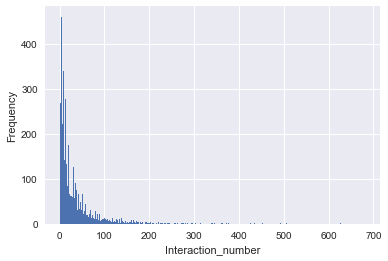

In [18]:
plt.hist(df.interaction_number, bins = 500) # bins = np.linspace(1,max(df.interaction_number),max(df.interaction_number)))
plt.ylabel('Frequency')
plt.xlabel('Interaction_number')
plt.show()

In [22]:
df2[df2.screen_number < 3].sort_values(by='total_time', ascending=False).head(10)

,screen_number,total_time,interaction_number
461,2,16956,28
122,1,12893,0
799,1,1349,74
57,2,909,8
186,1,839,37
435,2,720,39
950,2,682,32
609,1,542,84
332,1,512,13
916,2,491,1


Even with screen_number = 1, aka user only reached 1 screen, total_time can be extremely high. He opened the app and left it there? Or faulty data? I expected a more linear relationship

In [9]:
print(len(df[(df.screen_number <= 3) & (df.total_time > 180) & (df.interaction_number <= 10)]))
print(len(df[(df.screen_number <= 3) & (df.total_time > 180) & (df.interaction_number <= 10)])/len(df))

26
0.004679625629949604


Only 4% of sessions have less than 4 screens AND total time > 3 minutes. Recommend deleting them.

In [76]:
df2[df2.total_time <= 10]

,screen_number,total_time
10,1,8
30,2,4
44,1,4
81,2,9
82,1,3
84,2,5
85,2,8
104,1,0
151,1,6
161,1,9


In [11]:
extract_interaction_time_and_information(df['heatmap_timeline'][187])

[{'_screen': 'CreateProfileModalViewController',
  'interaction_count': 7,
  'interaction_time': array([ 0.404755  ,  0.57258099,  0.57315803,  0.69820303,  1.62592798,
          1.74047703,  3.11867404]),
  'start_time': 0,
  'view_time': 201}]

## Running DBSCAN on 3 variables above

In [116]:
df3.head(10)

,screen_number,total_time,interaction_number,interaction_bin,log_screen_number,log_total_time
1,5,114,35,3,1.609438,4.736198
2,5,109,32,3,1.609438,4.691348
3,3,76,8,1,1.098612,4.330733
4,2,98,42,4,0.693147,4.584967
5,6,263,110,4,1.791759,5.572154
6,1,119,11,2,0.000000,4.779123
7,13,255,59,4,2.564949,5.541264
8,16,338,121,4,2.772589,5.823046
9,2,94,37,3,0.693147,4.543295
10,1,8,4,1,0.000000,2.079442


In [117]:
X = df3[['screen_number', 'total_time', 'interaction_number']]

In [118]:
X = StandardScaler().fit_transform(X)

In [134]:
db = DBSCAN(eps=0.3, min_samples=10).fit_predict(X)

In [141]:
unique, counts = np.unique(db, return_counts=True)
print (np.asarray((unique, counts)).T)

[[ -1 127]
 [  0 813]]


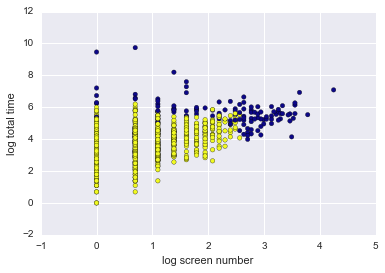

In [142]:
plt.scatter(x=df3.log_screen_number, y=df3.log_total_time, c=db, cmap = 'plasma')
plt.xlabel("log screen number")
plt.ylabel("log total time")

# Running LatentDirichletAllocation on all variables

In [165]:
features = ['device_class',
 'device_model_name',
 'device_name',
 'device_type',
 'first_activity',
 'height',
 'os_name',
 'preferences',
 'resolution',
 'sdk_version',
 'total_time',
 'unplayed',
 'used_app_version',
 'width',
 'ymd',
 'time_of_the_day',
 'time_formatted',
 'country_name',
 'country_code',
 'weekday',
 'continent',
 'screens_visited',
 'screen_number',
 'time_per_screen',
 'interaction_information',
 'interaction_number']

In [162]:
X_lda = df['interaction_information'].apply(str)

In [163]:
X_lda.shape

(1062,)

In [166]:
from sklearn.feature_extraction.text import CountVectorizer
vect_lda = CountVectorizer()

In [167]:
lda = LatentDirichletAllocation().fit_transform(vect_lda.fit_transform(X_lda))

F:\Python\lib\site-packages\sklearn\decomposition\online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [169]:
lda[0]

array([  7.69230940e-04,   7.69230940e-04,   7.69230940e-04,
         9.93076911e-01,   7.69230881e-04,   7.69230918e-04,
         7.69230939e-04,   7.69241934e-04,   7.69230875e-04,
         7.69230939e-04])

# Statistical tests to determine if countries affect average metrics:

In [25]:
denmark = df.screen_number[df.country_name == 'Denmark']

In [26]:
netherlands = df.screen_number[df.country_name == 'Netherlands']

In [27]:
denmark.describe()

count    235.000000
mean       4.336170
std        6.625657
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       70.000000
Name: screen_number, dtype: float64

In [28]:
netherlands.describe()

count    36.000000
mean      5.222222
std       6.436996
min       1.000000
25%       1.000000
50%       4.000000
75%       5.000000
max      33.000000
Name: screen_number, dtype: float64

In [29]:
scipy.stats.ttest_ind(denmark, netherlands)

Ttest_indResult(statistic=-0.74993343732629603, pvalue=0.45395017887387645)

In [30]:
usa = df.screen_number[df.country_name == 'United States']

In [31]:
scipy.stats.ttest_ind(usa, netherlands)

Ttest_indResult(statistic=-1.0482353914861817, pvalue=0.29708252424243503)

In [32]:
# Cannot reject null hypothesis that average screen_number between 2 countries are equal -> Assume they are equal

In [33]:
usa2 = df.total_time[df.country_name == 'United States']
netherlands2 = df.total_time[df.country_name == 'Netherlands']
denmark2 = df.total_time[df.country_name == 'Denmark']

In [34]:
print(scipy.stats.ttest_ind(usa2, netherlands2))
print(scipy.stats.ttest_ind(denmark2, netherlands2))
print(scipy.stats.ttest_ind(usa2, denmark2))

Ttest_indResult(statistic=-1.2749483619202515, pvalue=0.20531158631768487)
Ttest_indResult(statistic=0.36871647799245033, pvalue=0.71262908834154959)
Ttest_indResult(statistic=-0.76686406710650779, pvalue=0.44376943634919463)


In [35]:
(denmark2 / 60.).describe()

count    235.000000
mean       3.939504
std       23.186172
min        0.000000
25%        0.366667
50%        0.983333
75%        1.783333
max      282.600000
Name: total_time, dtype: float64

# Distribution of score (deprecated)

(array([ 334.,  169.,   96.,   59.,   60.,   35.,   24.,   18.,   18.,   80.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

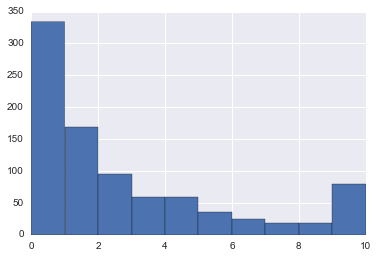

In [20]:
plt.hist(df.screen_score)

(array([ 251.,  170.,  130.,   88.,   66.,   29.,   27.,   19.,   19.,   94.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

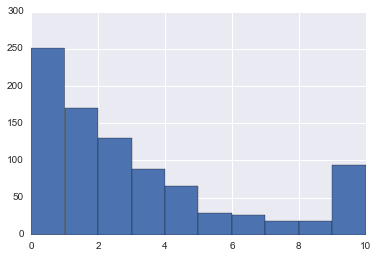

In [21]:
plt.hist(df.time_score)

# Journey (deprecated)

In [36]:
df[['screens_visited','screen_number','first_time_stage', 'photo_viewer_stage', 'active_use_stage',
       'beneficial_action_stage']].head(5)

,screens_visited,screen_number,first_time_stage,photo_viewer_stage,active_use_stage,beneficial_action_stage
1,"[UploadViewController, PhotoStreamViewController, PurchaseViewController, CouponModalViewController, UIAlertController]",5,0,1,1,1
2,"[UIAlertController, EventPageViewController, PhotoStreamViewController, EventPageViewController, UIAlertController]",5,0,1,0,0
3,"[UIAlertController, SupportViewController, MFMailComposeRemoteViewController]",3,0,0,0,0
4,"[SupportViewController, PhotoStreamViewController]",2,0,1,0,0
5,"[PhotoStreamViewController, PurchaseViewController, PhotoStreamViewController, PurchaseViewController, CouponModalViewController, UIAlertController]",6,0,2,0,2


In [37]:
print(max(df.first_time_stage))
print(max(df.photo_viewer_stage))
print(max(df.active_use_stage))
print(max(df.beneficial_action_stage))

7
9
15
5


In [38]:
df.active_use_stage.value_counts()

0     465
1      34
3      10
2       9
4       4
15      1
11      1
10      1
7       1
6       1
5       1
Name: active_use_stage, dtype: int64

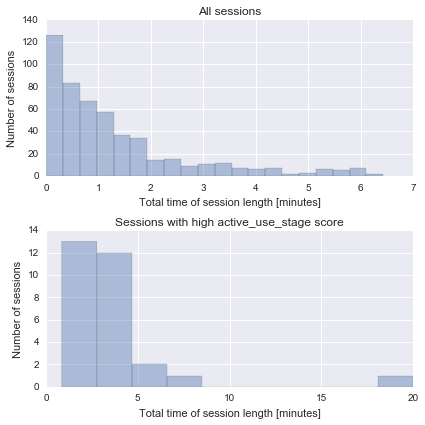

In [39]:
fig=plt.figure(figsize = [6, 6])

ax1 = fig.add_subplot(211)
sns.distplot(df[df['total_time'] < 400]['total_time'] / 60., ax=ax1, kde=False)
ax1.set_xlabel('Total time of session length [minutes]')
ax1.set_ylabel('Number of sessions')
ax1.set_title('All sessions')

ax2 = fig.add_subplot(212)
sns.distplot(df['total_time'][df.active_use_stage > 1] / 60., ax=ax2, kde=False, bins = 10)
ax2.set_xlabel('Total time of session length [minutes]')
ax2.set_ylabel('Number of sessions')
ax2.set_title('Sessions with high active_use_stage score')

plt.tight_layout()

In [40]:
## Plot for the device_id with the most sessions

In [17]:
most_session_user = df.device_id.value_counts().keys()[0]
df_most_use = df[df.device_id == most_session_user]

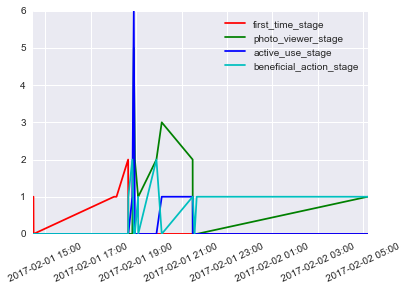

In [42]:
plt.plot(df_most_use.time_formatted, df_most_use.first_time_stage, 'r')
plt.plot(df_most_use.time_formatted, df_most_use.photo_viewer_stage, 'g')
plt.plot(df_most_use.time_formatted, df_most_use.active_use_stage, 'b')
plt.plot(df_most_use.time_formatted, df_most_use.beneficial_action_stage, 'c')
ax=plt.gca()
plt.xticks(rotation=25)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:00'))
plt.legend()

# NEW FKING IDEA!

Lets try to know a few information first:

1. max interaction per screen: 398
1. max number of screen per session: 70
1. remove swipe: done
1. deal with 1 screen high time: ???

In [161]:
df.to_csv('test_file_6_pages.csv') # Run topic modelling on BigML

In [170]:
df[['device_id','interaction_information']].to_csv('test_file_6_pages_just_interaction_information.csv')

In [5]:
# BigML doesn't provide anything useful

In [15]:
first_screen = df['screens_visited'].apply(lambda x: x[0])

# NOW IM ONLY WORKING WITH IOS DATASET

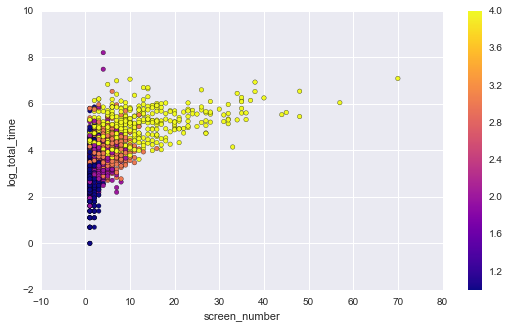

In [66]:
plot_time_vs_screen_vs_interaction(df_ios)

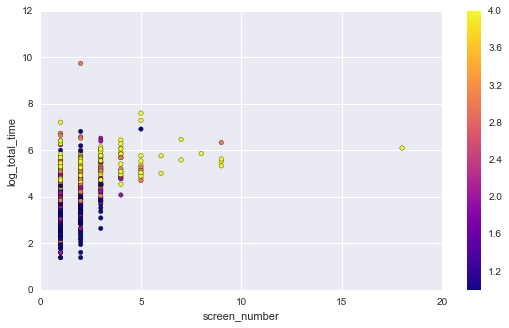

In [65]:
plot_time_vs_screen_vs_interaction(df_no_ios)

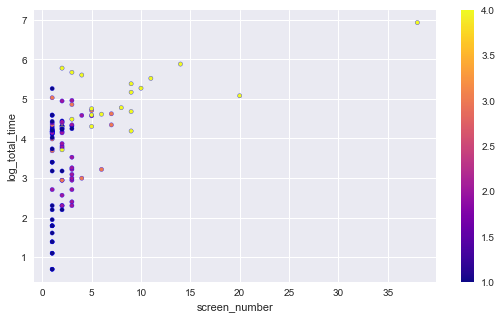

In [28]:
plot_time_vs_screen_vs_interaction(df_most_use)